# Compute the Density Of States (DOS) from VACF

In [1]:
import sys
import h5py
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import pythonpackage.computation
from pythonpackage.computation import correlation, window, gaussian
import pythonpackage.plot
from pythonpackage.plot import plot_dos
from notebookstyle import css_styling
%matplotlib inline
css_styling()

### Packages versions

In [2]:
print("Python version: {}".format(sys.version))
print("NumPy version: {}".format(np.__version__))
print("Scipy version: {}".format(sp.__version__))
print("h5py version: {}".format(h5py.__version__))
print("Matplotlib version: {}".format(mpl.__version__))
print("computation module version: {}".format(pythonpackage.computation.__version__))
print("plot module version: {}".format(pythonpackage.plot.__version__))

Python version: 3.6.2 |Intel Corporation| (default, Aug 15 2017, 17:12:56) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]
NumPy version: 1.13.1
Scipy version: 0.19.1
h5py version: 2.7.0
Matplotlib version: 2.0.2
computation module version: 0.2.0
plot module version: 0.3.0


## Read data

A 100ps molecular dynamics simulation (microcanonical (NVE) ensemble) of 256 water molecules (SPCE model).

In [3]:
file = 'Trajectories/spce300K_NVE_reduced_vacf.h5'

Explore the NetCDF file

In [4]:
with h5py.File(file, 'r') as f:
    ds = list(f.keys())
ds

['box_size', 'natoms', 'time', 'velocities']

Extract the datasets

In [5]:
with h5py.File(file, 'r') as f:
    time = np.copy(f['time'])
    box_size = np.copy(f['box_size'])
    velocities = np.copy(f['velocities'])
    natoms = np.copy(f['natoms'])

In [6]:
print(f"There are {natoms[0]} atoms and {time.shape[0]} steps.")
print(f"""The shape of the the velocities array is: {velocities.shape}. 
      The first dimension represents the steps, 
      the second dimension corresponds to the atoms and 
      the third dimension corresponds to the x, y, z velocities.""")

There are 768 atoms and 10001 steps.
The shape of the the velocities array is: (10001, 768, 3). 
      The first dimension represents the steps, 
      the second dimension corresponds to the atoms and 
      the third dimension corresponds to the x, y, z velocities.


## Compute VACF

For more details, see the vacf.ipynb notebook.

All VACFs

In [7]:
vacf = np.array([correlation(velocities[:, i, :]) for i in range(natoms[0])])

##### Oxygen atoms

In [8]:
vacf_O = vacf[2::3]
# mean vacf
vacf_O = vacf_O.mean(axis=0)

##### Hydrogen atoms

In [9]:
vacf_H1 = vacf[0::3]
vacf_H2 = vacf[1::3]
# mean vacf
vacf_H = (vacf_H1 + vacf_H2) / 2
vacf_H = vacf_H.mean(axis=0)

## Compute DOS

Parameters for the gaussian window

In [10]:
dt = (time[-1] - time[0]) / (len(time)-1)
dt

0.01

In [11]:
relative_width_of_sigma = 0.1
sigma = relative_width_of_sigma * time[-1]
sigma

10.0

Perform windowed FFT

In [12]:
vacf_O_window = window(vacf_O, window_function=gaussian(time, sigma=sigma))
vacf_H_window = window(vacf_H, window_function=gaussian(time, sigma=sigma))

In [13]:
dos_O = np.real(np.fft.fft(vacf_O_window))
dos_H = np.real(np.fft.fft(vacf_H_window))

The DOS is defined as the cosine transform of the VACF. Therefore the previous result has to be divided by 2:

In [14]:
dos_O = dos_O * dt / 2
dos_H = dos_H * dt / 2

## Plot DOS

In [15]:
df = 1 / (2 * time[-1])
freq = 2*np.pi*np.arange(len(time))*df

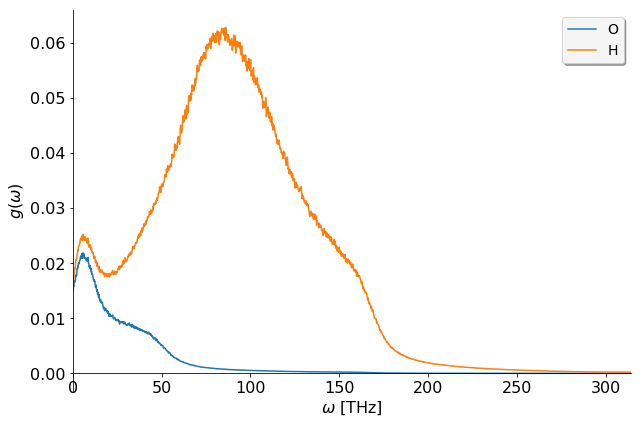

In [16]:
plot_dos(np.stack((freq, dos_O[:len(freq)])), np.stack((freq, dos_H[:len(freq)])), legend=["O", "H"], percentage=1)